## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from datetime import datetime
import seaborn as sns


#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#sisidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.narmax_tools import regressor_code

#Modelos
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
import xgboost as xgb

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score, mean_squared_error

# Disabling warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

# copiando sidmodel porque ele não estava escrevendo a ordem correta dos modelos
from copy import copy, deepcopy

#statsmodels for seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# import scienceplots
# plt.style.use(['science', 'ieee', 'notebook'])
plt.style.use(['seaborn-v0_8-whitegrid'])
# plt.style.use(['seaborn-whitegrid'])


c:\Users\bewm\AppData\Roaming\Python\env\env2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Passo 0 - Importando os dados

recovering from picke, comment if not necessary

In [2]:
# prefix = 'ENSV5B.MISO.W1'
# binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
# print(binary)

# with open(binary, 'rb') as bin_file:
#     X1_tr, y_tr, X1_te, y_te, order_progression2, df = pickle.load(bin_file)


### 0.1 - Lendo dados

In [3]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)


c:\Users\bewm\Documents\Projetos\Mestrado\SYSID_Trabalho\Volve-Dataset\data\volve_compiled.pkl


In [4]:
for wellp in data['OP'].keys():
    print(wellp)


15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Selecionando dados

In [9]:
# case = "15/9-F-1 C"
# case = "15/9-F-11" #muitos shut downs
# case = "15/9-F-12" #sem pdg
case = "15/9-F-14" # tentar prever qg?
# case = "15/9-F-15 D" # muita agua a partir de 600d
# case = "15/9-F-5" #

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        # 'BORE_LIQ_VOL',
        'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]


Plotando dados

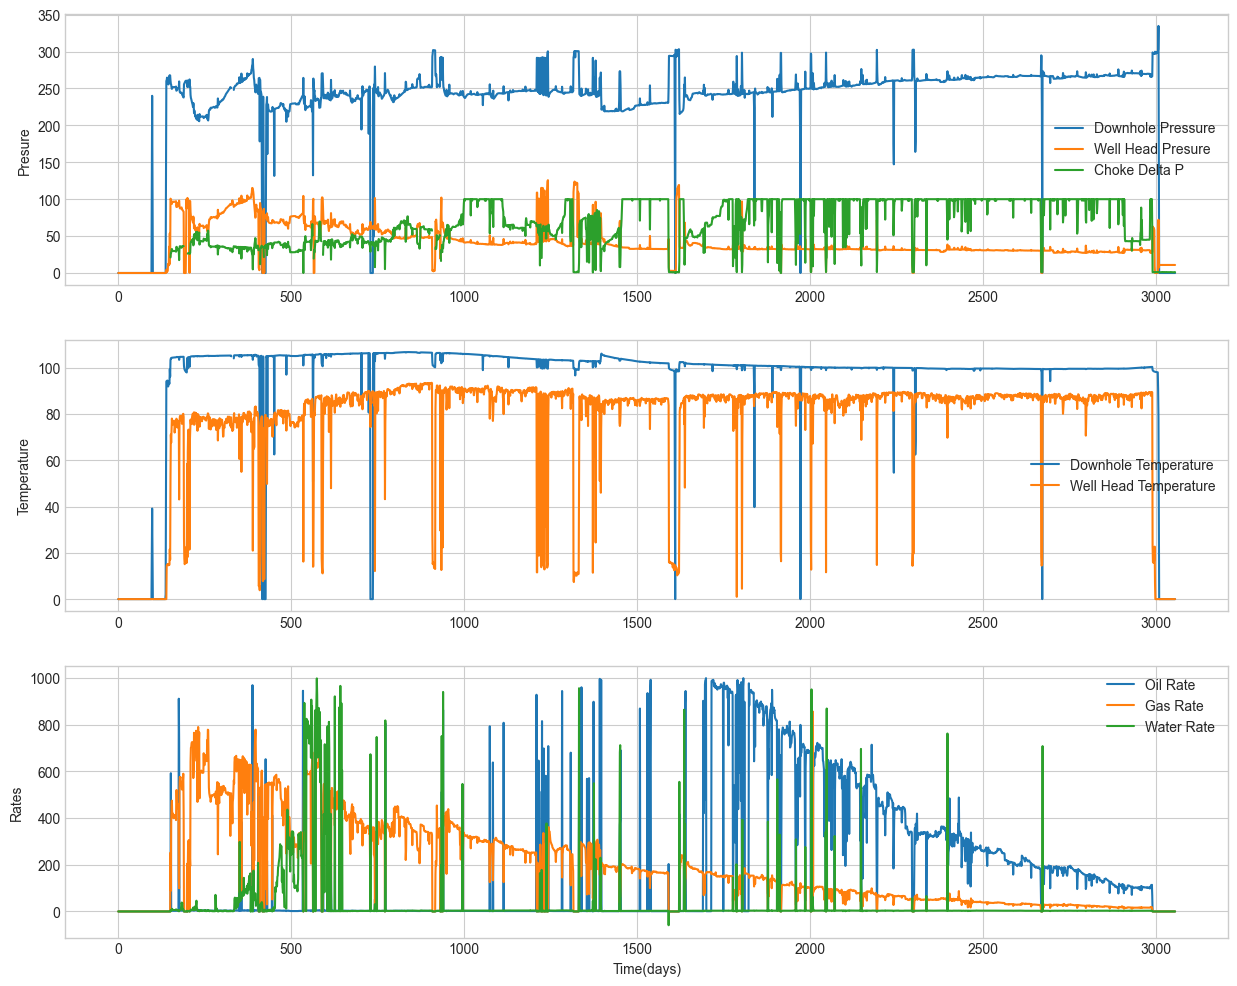

In [7]:
time = data_case['N']

plot_dict_P = {
'AVG_DOWNHOLE_PRESSURE':'Downhole Pressure',
'AVG_WHP_P':'Well Head Presure',
# 'AVG_DP_TUBING':'Tubing Delta P',
# 'AVG_ANNULUS_PRESS':'Annulus Pressure',
'AVG_CHOKE_SIZE_P':'Choke Delta P',
# 'DP_CHOKE_SIZE':'DP_CHOKE_SIZE_P',
}
plot_dict_T = {
'AVG_DOWNHOLE_TEMPERATURE':'Downhole Temperature',
'AVG_WHT_P':'Well Head Temperature',
}
plot_dict_Q = {
'BORE_OIL_VOL':'Oil Rate',
'BORE_GAS_VOL':'Gas Rate',
'BORE_WAT_VOL':'Water Rate',
}

fig, ax = plt.subplots(3,1, figsize=(15,12))

for k,v in plot_dict_P.items():
    ax[0].plot(time, data_case[k], label=v)

for k,v in plot_dict_T.items():
    ax[1].plot(time, data_case[k], label=v)

for k,v in plot_dict_Q.items():
    ax[2].plot(time, data_case[k], label=v)

ax[0].legend(fontsize='10')
ax[0].set_ylabel('Presure')

ax[1].legend(fontsize='10')
ax[1].set_ylabel('Temperature')

ax[2].legend(fontsize='10')
ax[2].set_xlabel('Time(days)')
ax[2].set_ylabel('Rates')


# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '0_well_data.eps')
# fig.savefig(p, format='eps')
pass;


In [10]:
data_case = data_case.iloc[28:,:]
data_case = data_case[filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values


## Seasonal decompose

Sem decompor as entradas por enquanto


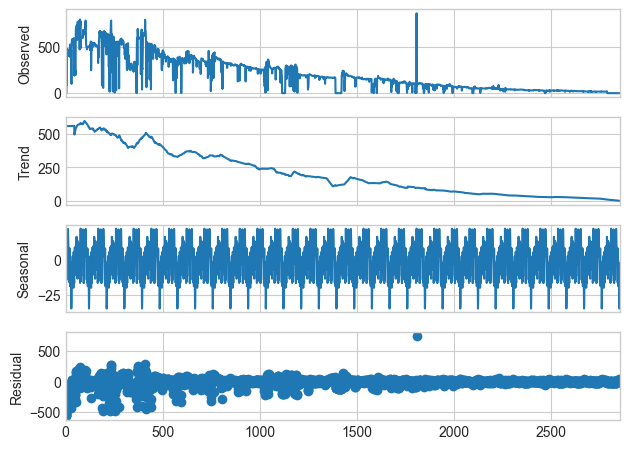

In [15]:
result = seasonal_decompose(y, model='additive', period=91, extrapolate_trend='freq')
fig = result.plot()
yt=result.trend.reshape(-1,1)
ys=result.seasonal.reshape(-1,1)
yr=result.resid.reshape(-1,1)

fig.axes[0].set_ylabel('Observed')
fig.axes[0].set_title('')

pass;


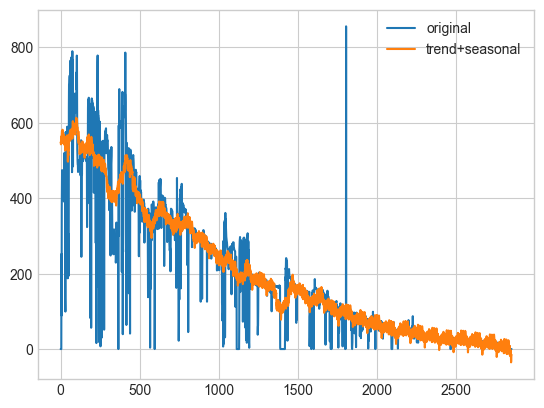

In [16]:
plt.plot(y, label='original')
plt.plot(yt+ys, label='trend+seasonal')
plt.legend()


## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [17]:
p_train = 0.7 #70% treino


### 1.2 - Separando os conjuntos

In [18]:
n_train = int(X1.shape[0]*p_train)

X1_tr = X1[:n_train,:]
X1_te = X1[:,:]

y_tr = y[:n_train,:]
y_te = y[:,:]


In [19]:
print(
    X1.shape,
    X1_tr.shape,
    X1_te.shape
)
print(
    y.shape,
    y_tr.shape,
    y_te.shape,
)


(2854, 5) (1997, 5) (2854, 5)
(2854, 1) (1997, 1) (2854, 1)


### 1.3 - Removendo a escala 

In [20]:
s = MinMaxScaler()
X_tr = s.fit_transform(X1_tr)
X_te = s.fit_transform(X1_te)

y_tr = s.fit_transform(y_tr)
y_te = s.fit_transform(y_te)


## Passo 2 - Declarando os modelos 

In [21]:
models = []


### 2.3 - Modelos de ML (sklearn)

#### 2.3.1 - Modelos

In [22]:
models_ml = [
    ('LinReg'             ,      LinearRegression(copy_X=True)), #ARX Equivalet
    ('RidgeReg'           ,      Ridge()),
    ('PolyReg'            ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivale)t
    ('SVM'                ,      SVR(max_iter=-1)),
    ('KNN'                ,      KNeighborsRegressor()),
    ('MLP'                ,      MLPRegressor(random_state=rs)),
    ('DecisionTree'       ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'       ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting'   ,      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'         ,      ExtraTreesRegressor(random_state=rs)),
    ('AdaBoostRegressor'  ,      AdaBoostRegressor(random_state=rs)),
    ('BaggingRegressor'   ,      BaggingRegressor(random_state=rs)),
    ('LightGBM'           ,      lgb.LGBMRegressor()),
    ('XGBoost'            ,      xgb.XGBRegressor()),
]

for i, m in enumerate(models_ml):
    # print (m[0])
    print (i, m[0])


0 LinReg
1 RidgeReg
2 PolyReg
3 SVM
4 KNN
5 MLP
6 DecisionTree
7 RandomForest
8 GradientBoosting
9 ExtraTrees
10 AdaBoostRegressor
11 BaggingRegressor
12 LightGBM
13 XGBoost


#### 2.3.2 - Parâmetros (RandomSearchCV)

In [40]:

parameters = [
    { # LinReg 0
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # RidgeReg 1
        'positive'                     : [True, False],
    },
    { # PolyReg NARX 3
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        #'Poly__degree'                : [2, 3, 4, 5],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # SVM 4
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # KNN 5
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # MLP 6
        'activation'            : ['relu', 'tanh'],
        'early_stopping'        : [True],
        'learning_rate_init'    : stats.loguniform(1e-4, 0.01),
        # 'learning_rate'         : ['adaptive', 'constant'],
        'alpha'                 : stats.loguniform(1e-5, 1e-3),
        'hidden_layer_sizes'    : []
        + [n_neurons for n_neurons in itertools.product([20, 60], repeat=1)]
        + [n_neurons for n_neurons in itertools.product([20, 60], repeat=2)]
        + [n_neurons for n_neurons in itertools.product([20, 60], repeat=3)],
        # 'max_iter'              : [10000],#stats.randint(200,10000),
        # 'batch_size'            : [32],
        # 'solver'                : ['adam'], #'lbfgs'],
        'tol'                   : stats.loguniform(1e-7, 1e-1),
    },
    { # DecisionTree 7
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # RandomForest 8
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # GradientBoosting 9
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(),
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # ExtraTrees 10
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    { # AdaBoostRegressor 11
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 10),
        'loss'                      : ['linear', 'square', 'exponential'],
    },
    { # BaggingRegressor 12
        'n_estimators'              : stats.randint(5,100), #Numero de arvores
        'max_samples'               : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_features'              : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'bootstrap'                 : [True, False],      #maxima quantidade de features para embasar a decisao de divisao
    },
    { # LightGBM 13
        'num_leaves'                : stats.randint(5,100), # max num folhas dos base learners
        'n_estimators'              : stats.randint(10,200), #Numero de arvores
        'learning_rate'             : stats.loguniform(1e-3, 1),
        # 'max_depth'                 : stats.randint(1,20), #maxima profundidade da arvore
    },
    { # XGBoost 14
        'n_estimators'           : stats.randint(2,100), #Numero de arvores
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'learning_rate'          : stats.loguniform(1e-3, 1),
    },
]


In [59]:
kfolds = 5
niters = 3
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)


In [42]:
n_iter = 30 #Numero de iterações do rdmsearch
models = []
for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2', param_distributions=params, n_iter=n_iter, n_jobs=6, cv=rkf, random_state=rs)

    sidmodel = SYSIDRegressor(
        nX=6, ny=6,
        estimator=rdmsearch,
        )

    models.append(
        (model[0], sidmodel)
    )


In [43]:
# 0 LinReg
# 1 RidgeReg
# 2 PolyReg
# 3 SVM
# 4 KNN
# 5 MLP
# 6 DecisionTree
# 7 RandomForest
# 8 GradientBoosting
# 9 ExtraTrees
# 10 AdaBoostRegressor
# 11 BaggingRegressor
# 12 LightGBM
# 13 XGBoost
models_choice = [0,1,2,4,5,7,8,11,12,13]
# models_choice = [0,1]
for model in np.array(models)[models_choice]:
    print (model[0])


LinReg
RidgeReg
PolyReg
KNN
MLP
RandomForest
GradientBoosting
BaggingRegressor
LightGBM
XGBoost


In [85]:
orders = [2, 3, 6, 12, 15, 20]
# orders = [20]


In [45]:
results_dict = {
    'MODEL1':[],
    'MODEL2':[],
    'ORDER':[],
    'R2_TRAIN_OSA':[],
    'R2_TEST_OSA':[],
    'R2_TRAIN_FS':[],
    'R2_TEST_FS':[],
    'RMSE_TRAIN_OSA':[],
    'RMSE_TEST_OSA':[],
    'RMSE_TRAIN_FS':[],
    'RMSE_TEST_FS':[],
    'MODEL_OBJ1':[],
    'MODEL_OBJ2':[],
}


In [60]:
t00 = datetime.now()

#Loop principal, iterando sobre as listas
for order in orders:
    print(f'Order {order}')

    t0 = datetime.now()

    for model in np.array(models)[models_choice]:

        # Training Step 1: full training set
        model_name, sidmodel = model
        print(f'Training Step 1: {model_name} ', end='')
        sidmodel.nX = order
        sidmodel.ny = order

        # train
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)

        # predictions
        y_hat_te_osa = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
        y_hat_tr_osa = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)
        y_hat_te_fs  = sidmodel.predict(X1_te, y=y_te )
        y_hat_tr_fs  = sidmodel.predict(X1_tr, y=y_tr )

        # score
        r2_tr_osa = r2_score(y_tr,  y_hat_tr_osa)
        r2_te_osa = r2_score(y_te,  y_hat_te_osa)
        rmse_tr_osa = mean_squared_error(y_tr, y_hat_tr_osa)**0.5
        rmse_te_osa = mean_squared_error(y_te, y_hat_te_osa)**0.5
        try:
            r2_tr_fs = r2_score(y_tr, y_hat_tr_fs)
            r2_te_fs = r2_score(y_te, y_hat_te_fs)
            rmse_tr_fs = mean_squared_error(y_tr, y_hat_tr_fs)**0.5
            rmse_te_fs = mean_squared_error(y_te, y_hat_te_fs)**0.5
        except ValueError:
            r2_tr_fs = 1e290
            r2_te_fs = 1e290
            rmse_tr_fs = 1e290
            rmse_te_fs = 1e290

        # save and write
        results_dict['MODEL1'].append(model_name)
        results_dict['MODEL2'].append('-')
        results_dict['ORDER'].append(order)
        results_dict['R2_TRAIN_OSA'].append(r2_tr_osa)
        results_dict['R2_TEST_OSA'].append(r2_te_osa)
        results_dict['R2_TRAIN_FS'].append(r2_tr_fs)
        results_dict['R2_TEST_FS'].append(r2_te_fs)
        results_dict['RMSE_TRAIN_OSA'].append(rmse_tr_osa)
        results_dict['RMSE_TEST_OSA'].append(rmse_te_osa)
        results_dict['RMSE_TRAIN_FS'].append(rmse_tr_fs)
        results_dict['RMSE_TEST_FS'].append(rmse_te_fs)
        results_dict['MODEL_OBJ1'].append(deepcopy(sidmodel))
        results_dict['MODEL_OBJ2'].append(None)
        print(f'\t\tR2.OSA(Test)={r2_te_osa:.4f}, R2.FS(Test)={r2_te_fs:.4f}\n')

        # ###################################################
        # Training Step 2: training on train set residuals
        # ###################################################

        # residuals
        yr_tr = y_tr - y_hat_tr_osa
        yr_te = y_te - y_hat_te_osa

        for model_res in np.array(models)[models_choice]:
            model_name_res, sidmodel_res  = model_res
            print(f'\t Step 2: +{model_name_res}', end='')
            sidmodel_res.nX = order
            sidmodel_res.ny = order

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                sidmodel_res.fit(X=X1_tr, y=yr_tr)

            # predictions
            yr_hat_te_osa = sidmodel_res.predict(X1_te, y=yr_te, steps_ahead=1)
            yr_hat_tr_osa = sidmodel_res.predict(X1_tr, y=yr_tr, steps_ahead=1)
            try:
                yr_hat_te_fs  = sidmodel_res.predict(X1_te, y=yr_te)
                yr_hat_tr_fs  = sidmodel_res.predict(X1_tr, y=yr_tr)
            except ValueError:
                yr_hat_te_fs  = np.zeros(len(y_te))
                yr_hat_tr_fs  = np.zeros(len(y_te))
            # combined (final) predictions
            yf_hat_tr_osa = y_hat_tr_osa + yr_hat_tr_osa
            yf_hat_te_osa = y_hat_te_osa + yr_hat_te_osa
            yf_hat_tr_fs = y_hat_tr_fs + yr_hat_tr_fs
            yf_hat_te_fs = y_hat_te_fs + yr_hat_te_fs

            # score
            r2f_tr_osa = r2_score(y_tr,  yf_hat_tr_osa)
            r2f_te_osa = r2_score(y_te,  yf_hat_te_osa)
            rmsef_tr_osa = mean_squared_error(y_tr, yf_hat_tr_osa)**0.5
            rmsef_te_osa = mean_squared_error(y_te, yf_hat_te_osa)**0.5
            try:
                r2f_tr_fs = r2_score(y_tr, yf_hat_tr_fs)
                r2f_te_fs = r2_score(y_te, yf_hat_te_fs)
                rmsef_tr_fs = mean_squared_error(y_tr, yf_hat_tr_fs)**0.5
                rmsef_te_fs = mean_squared_error(y_te, yf_hat_te_fs)**0.5
            except ValueError:
                r2f_tr_fs = 1e290
                r2f_te_fs = 1e290
                rmsef_tr_fs = 1e290
                rmsef_te_fs = 1e290

            results_dict['MODEL1'].append(model_name)
            results_dict['MODEL2'].append(model_name_res)
            results_dict['ORDER'].append(order)
            results_dict['R2_TRAIN_OSA'].append(r2f_tr_osa)
            results_dict['R2_TEST_OSA'].append(r2f_te_osa)
            results_dict['R2_TRAIN_FS'].append(r2f_tr_fs)
            results_dict['R2_TEST_FS'].append(r2f_te_fs)
            results_dict['RMSE_TRAIN_OSA'].append(rmsef_tr_osa)
            results_dict['RMSE_TEST_OSA'].append(rmsef_te_osa)
            results_dict['RMSE_TRAIN_FS'].append(rmsef_tr_fs)
            results_dict['RMSE_TEST_FS'].append(rmsef_te_fs)
            results_dict['MODEL_OBJ1'].append(deepcopy(sidmodel))
            results_dict['MODEL_OBJ2'].append(deepcopy(sidmodel_res))
            print(f'\t\tR2.OSA(Test)={r2f_te_osa:.4f}, R2.FS(Test)={r2f_te_fs:.4f}, R2 Increase={100*(r2f_te_fs/r2_te_fs-1):.1f}%')

    print(f'Tempo (ordem): {datetime.now()-t0}\nTempo (acum): {datetime.now()-t00}\n')


Order 20
Training Step 1: LinReg 		R2.OSA(Test)=0.8968, R2.FS(Test)=0.7285

	 Step 2: +LinReg		R2.OSA(Test)=0.8973, R2.FS(Test)=0.7282, R2 Increase=-0.0%
	 Step 2: +RidgeReg		R2.OSA(Test)=0.8973, R2.FS(Test)=0.7284, R2 Increase=-0.0%
	 Step 2: +PolyReg		R2.OSA(Test)=0.9160, R2.FS(Test)=100000000000000006172783352786715688699437231096301125831005285053881337653967155894253917094446479669431045845149126131034590785433956171738211535366987228554259102109161882186134743033813753627273385960246277244994846257890348030815401124236704201912132575831851305036088950921132601507840.0000, R2 Increase=13726716723938447567350447993860844876659586113089901176307051957077834845246959966177975727376401178284374888693654301372015693641046350970512173959053262939490693108049152566182424211771317099460690508763541595026291325688358350112255213822938656057330379704104533822467824955369622364749824.0%
	 Step 2: +KNN		R2.OSA(Test)=0.9971, R2.FS(Test)=0.7630, R2 Increase=4.7%
	 Step 2: +MLP		R2.OSA(Test)=0.8

In [66]:
df = pd.DataFrame(results_dict)


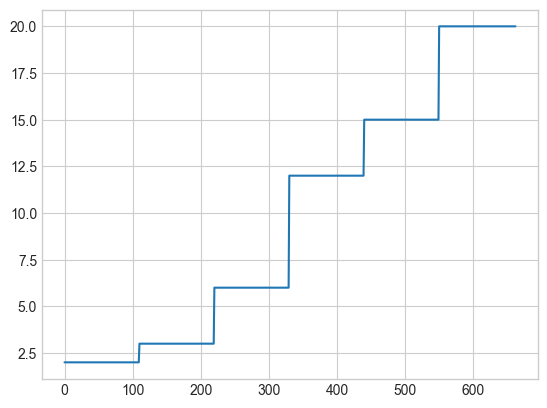

In [67]:
plt.plot(df.ORDER)


Trocando valores expurios por NaN

In [68]:
df2 = df.copy()
df2.loc[df['R2_TEST_FS']<-2, ['R2_TRAIN_OSA','R2_TEST_OSA','R2_TRAIN_FS','R2_TEST_FS']] = np.nan
df2.loc[df['R2_TEST_FS']>1e6, ['R2_TRAIN_OSA','R2_TEST_OSA','R2_TRAIN_FS','R2_TEST_FS','RMSE_TRAIN_FS','RMSE_TEST_FS']] = np.nan
df2.sort_values('R2_TEST_FS')


,MODEL1,MODEL2,ORDER,R2_TRAIN_OSA,R2_TEST_OSA,R2_TRAIN_FS,R2_TEST_FS,RMSE_TRAIN_OSA,RMSE_TEST_OSA,RMSE_TRAIN_FS,RMSE_TEST_FS,MODEL_OBJ1,MODEL_OBJ2
38,KNN,MLP,2,0.487074,0.455617,0.299464,0.336407,0.146012,0.158176,0.170638,0.174638,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
485,MLP,LinReg,15,0.799571,0.812054,0.652807,0.341019,0.091273,0.092941,0.120129,0.174030,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
487,MLP,PolyReg,15,0.813039,0.818504,0.612223,0.419551,0.088153,0.091332,0.126956,0.163332,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
484,MLP,-,15,0.669893,0.462385,0.638324,0.429239,0.117135,0.157190,0.122609,0.161963,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None
494,MLP,XGBoost,15,0.845503,0.682112,0.621398,0.470472,0.080135,0.120872,0.125445,0.156003,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,GradientBoosting,BaggingRegressor,3,0.968225,0.976169,0.830857,0.887061,0.036342,0.033095,0.083847,0.072046,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
556,LinReg,PolyReg,20,NaN,NaN,NaN,NaN,0.072481,0.062137,NaN,NaN,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
567,RidgeReg,PolyReg,20,NaN,NaN,NaN,NaN,0.069216,0.060757,NaN,NaN,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
611,RandomForest,PolyReg,20,NaN,NaN,NaN,NaN,0.056134,0.123207,NaN,NaN,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...


Criando flag de treinamento em 2 etapas

In [69]:
df2['STEPS'] = '2'
df2.loc[df2['MODEL2']=='-', ['STEPS']] = '1'
df2.value_counts('STEPS')


STEPS
2    602
1     61
dtype: int64

Renomeando modelos para facilitar os plots

In [70]:
df2.rename(columns={'MODEL1':'BASE_MODEL', 'MODEL2':'RESIDUAL_MODEL'}, inplace=True)


In [71]:
### Salvando


In [72]:
prefix = 'DECV1.MISO.W3_G'
binary = os.path.join(os.getcwd(), 'outputs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump((X1_tr, y_tr, X1_te, y_te, results_dict, df2), bin_file)


c:\Users\bewm\Documents\Projetos\Mestrado\SYSID_Trabalho\Volve-Dataset\outputs\DECV1.MISO.W3_G_ml.pkl


# Analysis

<Axes: xlabel='ORDER', ylabel='R2_TEST_FS'>

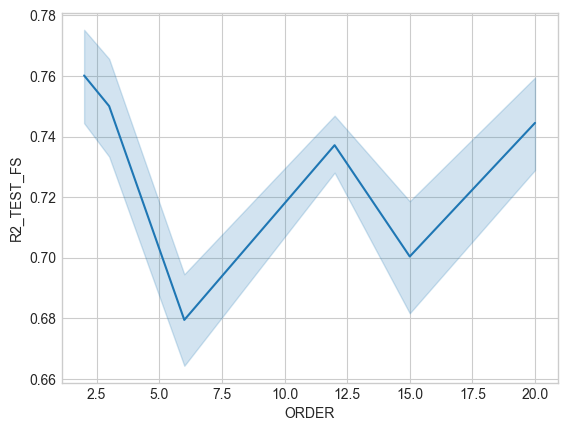

In [73]:
sns.lineplot(data=df2, x='ORDER', y='R2_TEST_FS')


<Axes: xlabel='R2_TEST_FS', ylabel='Density'>

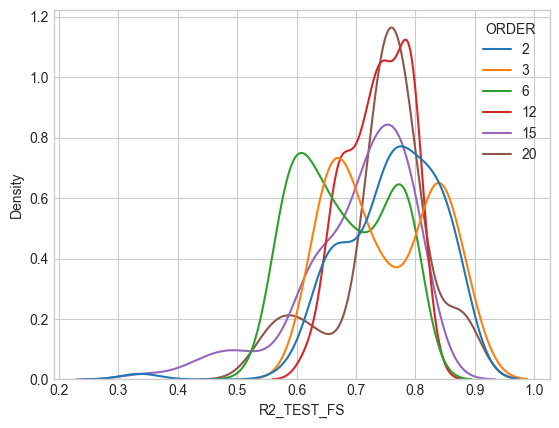

In [74]:
sns.kdeplot(data=df2, x='R2_TEST_FS', hue='ORDER', palette='tab10')


(0.4, 0.9)

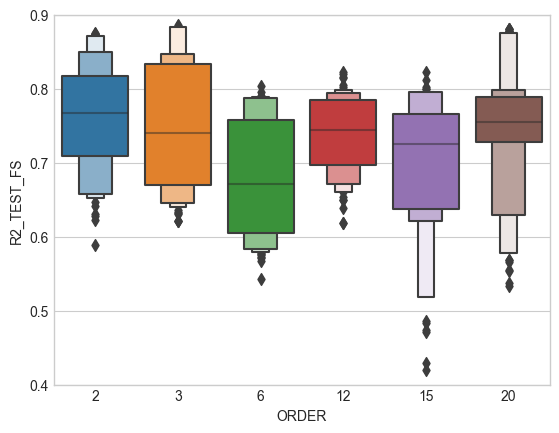

In [77]:
# sns.boxplot(data=df2, x='ORDER', y='R2_TEST_FS',showmeans=False, meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black", "markersize":8},)
sns.boxenplot(data=df2, x='ORDER', y='R2_TEST_FS')
plt.ylim([0.4,.9])


Resultados

(0.45, 0.9)

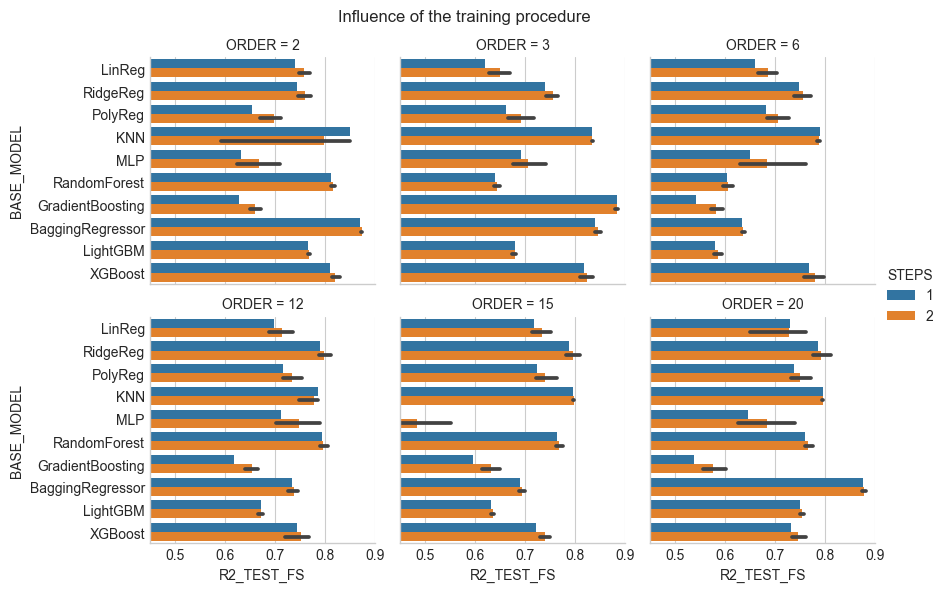

In [78]:
c = sns.catplot(data=df2, x='R2_TEST_FS', y='BASE_MODEL', hue='STEPS', col='ORDER', col_wrap=3, errorbar=('ci',100), kind='bar',  height=3, aspect=1 )
c.fig.suptitle('Influence of the training procedure', size=12)
c.fig.subplots_adjust(top=.9)
plt.xlim([.45,.90])


Reanqueamento dos melhores casos

In [82]:
df_rank = df2.sort_values(by='R2_TEST_FS', ascending=False).drop_duplicates(subset=['BASE_MODEL', 'RESIDUAL_MODEL']).reset_index()
df_rank.to_clipboard()
df_rank.head(10)


,index,BASE_MODEL,RESIDUAL_MODEL,ORDER,R2_TRAIN_OSA,R2_TEST_OSA,R2_TRAIN_FS,R2_TEST_FS,RMSE_TRAIN_OSA,RMSE_TEST_OSA,RMSE_TRAIN_FS,RMSE_TEST_FS,MODEL_OBJ1,MODEL_OBJ2,STEPS
0,184,GradientBoosting,BaggingRegressor,3,0.968225,0.976169,0.830857,0.887061,0.036342,0.033095,0.083847,0.072046,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
1,186,GradientBoosting,XGBoost,3,0.924044,0.946979,0.827085,0.884607,0.056188,0.049364,0.084777,0.072824,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
2,182,GradientBoosting,RandomForest,3,0.923625,0.947451,0.826481,0.884192,0.056343,0.049144,0.084925,0.072955,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
3,185,GradientBoosting,LightGBM,3,0.919268,0.945835,0.824957,0.884027,0.057927,0.049894,0.085297,0.073007,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
4,183,GradientBoosting,GradientBoosting,3,0.917529,0.944826,0.824406,0.883763,0.058548,0.050356,0.085431,0.073090,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
5,176,GradientBoosting,-,3,0.916938,0.943949,0.825146,0.883673,0.058757,0.050755,0.085251,0.073119,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None,1
6,180,GradientBoosting,KNN,3,0.919050,0.945439,0.824483,0.883474,0.058006,0.050076,0.085413,0.073181,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
7,178,GradientBoosting,RidgeReg,3,0.917592,0.944322,0.824438,0.883279,0.058526,0.050586,0.085423,0.073243,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
8,177,GradientBoosting,LinReg,3,0.917689,0.944527,0.824400,0.883230,0.058491,0.050493,0.085433,0.073258,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
9,179,GradientBoosting,PolyReg,3,0.918628,0.945606,0.824112,0.883065,0.058157,0.049999,0.085503,0.073310,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2


Swarm Plots mustirando as ordens

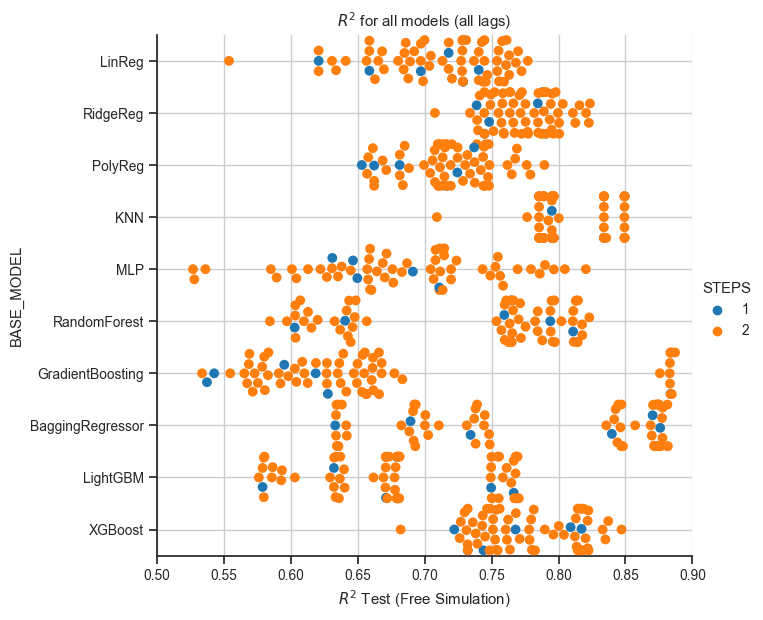

In [83]:

sns.set(font_scale=.9, style='ticks')

catplot = sns.catplot(data=df2, y='BASE_MODEL', x='R2_TEST_FS', hue='STEPS', kind='swarm', height=6, aspect=1.2, s=50, palette='tab10')
plt.xlim((.5,.9))
plt.grid()
plt.xlabel('$R^2$ Test (Free Simulation)')
plt.title('$R^2$ for all models (all lags)')
pass;

# fig = catplot.fig
# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '3_r2_swarm.eps')
# fig.savefig(p, format='eps')


Scatterplot variando as ordens

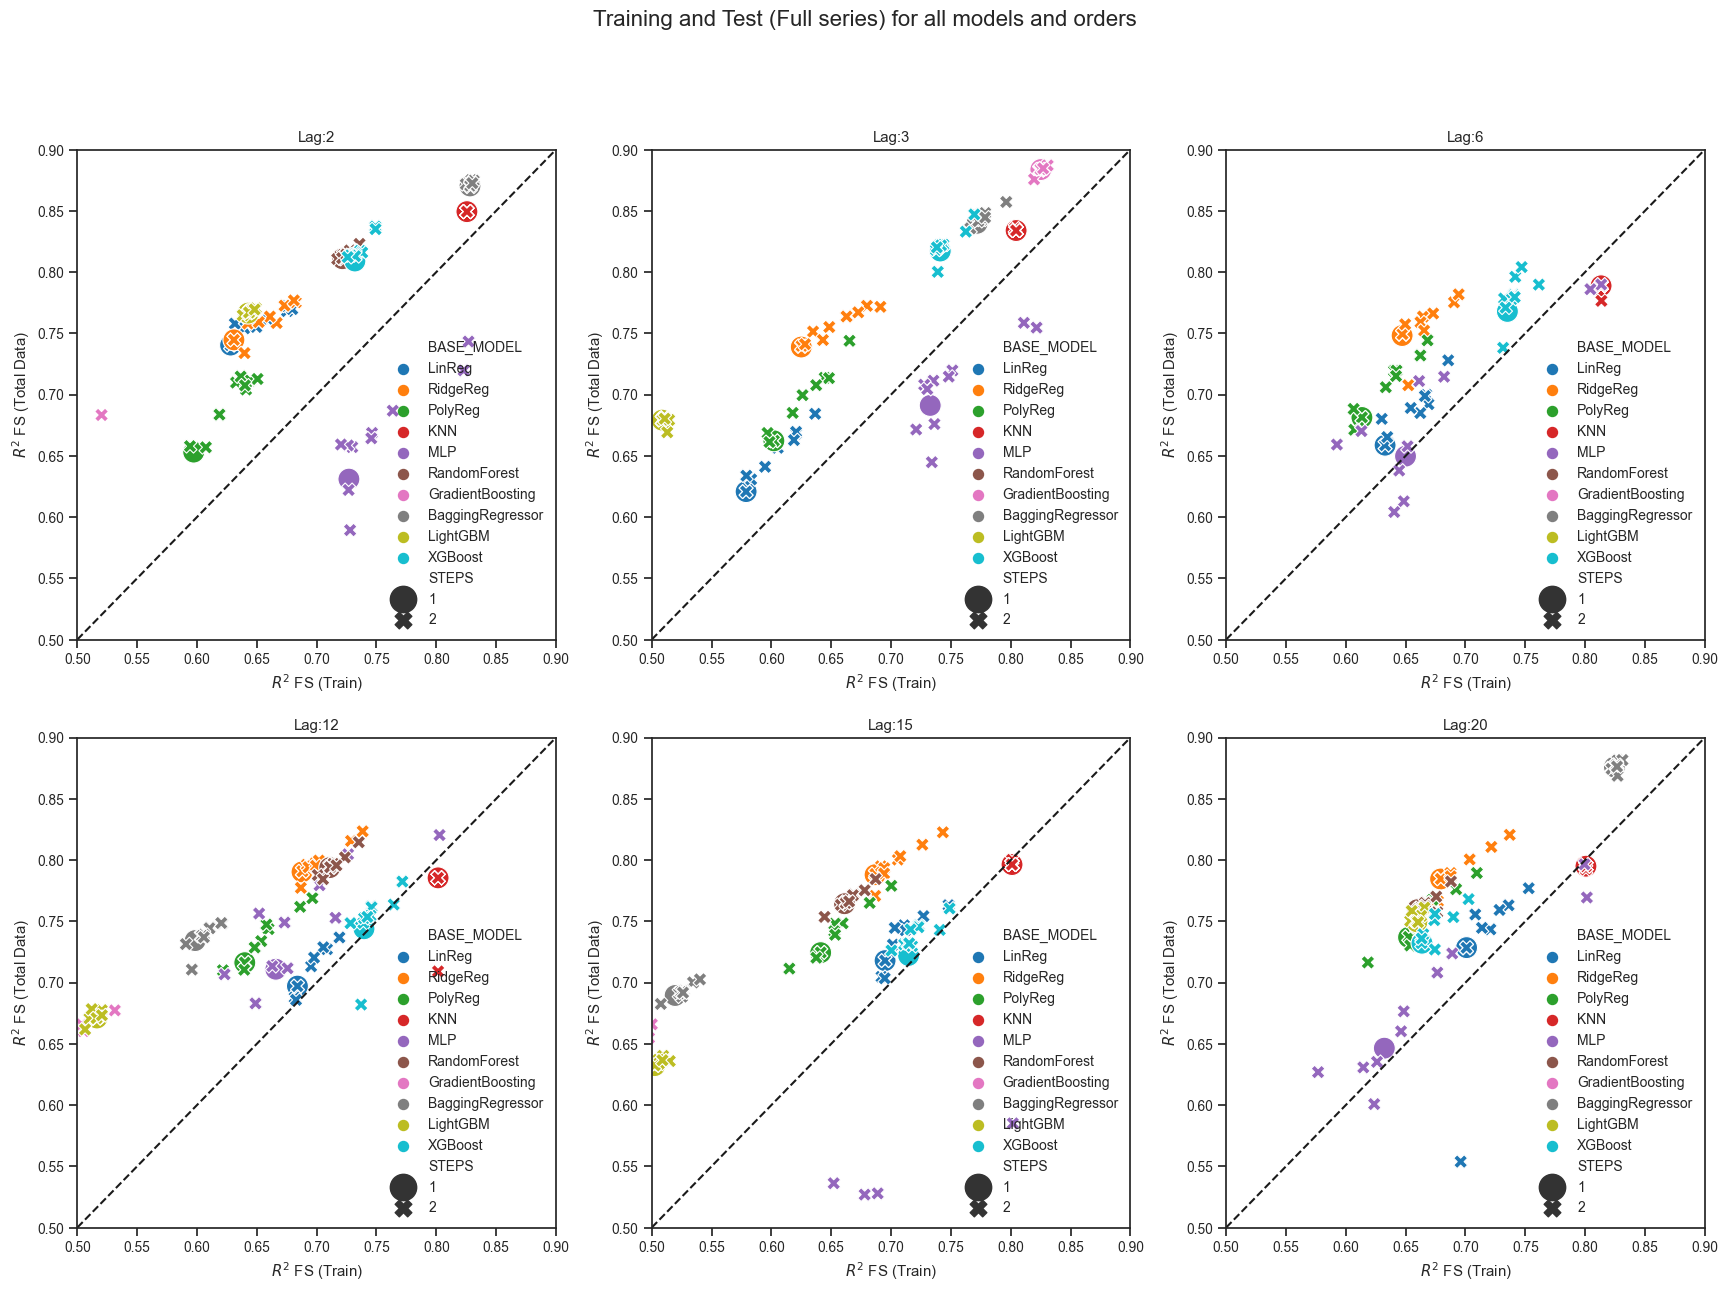

In [88]:
lim=(.5,.9)
fig, ax = plt.subplots(2,3, figsize=(21,14))

ax = ax.flatten()

fig.suptitle('Training and Test (Full series) for all models and orders', fontsize=16)

for i,o in enumerate (orders):
# for i,o in enumerate (orders[:-2]):
    sns.scatterplot(data=df2[df['ORDER']==o], x='R2_TRAIN_FS', y='R2_TEST_FS', hue='BASE_MODEL', ax=ax[i], size='STEPS', style='STEPS', sizes=(100,250), palette='tab10');
    ax[i].plot(lim, lim, '--', c='k')
    ax[i].set_xlim(lim)
    ax[i].set_ylim(lim)
    ax[i].set_title(f'Lag:{o}')
    ax[i].set_xlabel(f'$R^2$ FS (Train)')
    ax[i].set_ylabel(f'$R^2$ FS (Total Data)')
    ax[i].legend(fontsize=10, markerscale=1.2,)
pass;

# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '4_results_scatter.eps')
# fig.savefig(p, format='eps')
#     ax[i].set_ylabel(f'$R^2$ FS (Test)')
# pass;


Predictions

In [90]:
order = 3
_, sidmodel = models[8]
_, sidmodel_res = models[11]
sidmodel.nX = order
sidmodel.ny = order
sidmodel_res.nX = order
sidmodel_res.ny = order

# train
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel.fit(X=X1_tr, y=y_tr)

# predictions
y_hat_te_osa = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
y_hat_tr_osa = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)
y_hat_te_fs = sidmodel.predict(X1_te, y=y_te)

# ###################################################
# Training Step 2: training on train set residuals
# ###################################################
# residuals
yr_tr = y_tr - y_hat_tr_osa
yr_te = y_te - y_hat_te_osa

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel_res.fit(X=X1_tr, y=yr_tr)

# predictions
yr_hat_te_fs  = sidmodel_res.predict(X1_te, y=yr_te)
# combined (final) predictions
yf_hat_te_fs = y_hat_te_fs + yr_hat_te_fs

r2_score(y_te, y_hat_te_fs), r2_score(y_te, yf_hat_te_fs)


(0.8836725078366127, 0.8870611295803136)

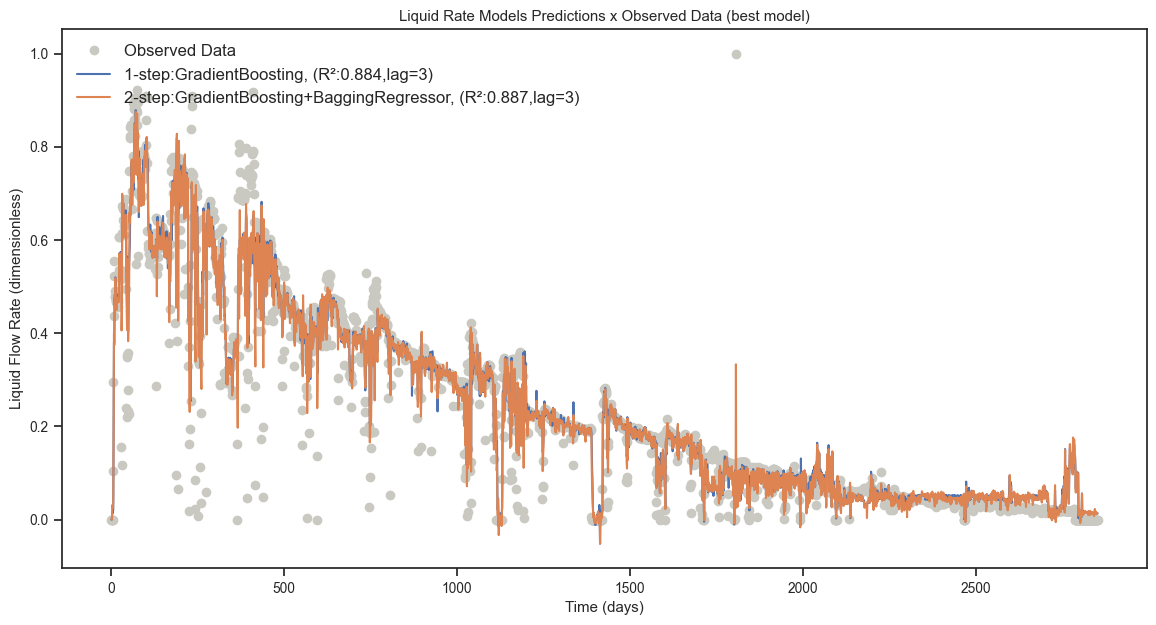

In [91]:
fig = plt.figure(figsize=(14,7))
plt.plot(y_te, 'o', label='Observed Data', c='#c9c9c1')

# plot best modl predictions
plt.plot(y_hat_te_fs, label=f"1-step:{df_rank.loc[5,'BASE_MODEL']}, (R²:{df_rank.loc[5,'R2_TEST_FS']:.3f},lag={df_rank.loc[5,'ORDER']})")
plt.plot(yf_hat_te_fs, label=f"2-step:{df_rank.loc[0,'BASE_MODEL']}+{df_rank.loc[0,'RESIDUAL_MODEL']}, (R²:{df_rank.loc[0,'R2_TEST_FS']:.3f},lag={df_rank.loc[0,'ORDER']})")
plt.legend()

plt.ylabel('Gas Flow Rate (dimensionless)')
plt.xlabel('Time (days)')
plt.legend(fontsize='12', loc='upper left')
plt.title('Gas Rate Models Predictions x Observed Data (best model)')

# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '6_predictions_best_W1.eps')
# fig.savefig(p, format='eps')
pass;


Plotando previsões onde o treinamento 2-step fez diferença

In [93]:
df2[(df2['BASE_MODEL'] == 'MLP') & (df2['ORDER'] == 6)].head(10)


,BASE_MODEL,RESIDUAL_MODEL,ORDER,R2_TRAIN_OSA,R2_TEST_OSA,R2_TRAIN_FS,R2_TEST_FS,RMSE_TRAIN_OSA,RMSE_TEST_OSA,RMSE_TRAIN_FS,RMSE_TEST_FS,MODEL_OBJ1,MODEL_OBJ2,STEPS
264,MLP,-,6,0.679298,0.661356,0.649891,0.649674,1.154548e-01,0.124756,0.120632,0.126889,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,None,1
265,MLP,LinReg,6,0.802542,0.862522,0.661255,0.711028,9.059377e-02,0.079489,0.118658,0.115243,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
266,MLP,RidgeReg,6,0.813049,0.861377,0.644606,0.637971,8.815070e-02,0.079819,0.121539,0.128991,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
267,MLP,PolyReg,6,0.816443,0.804617,0.613055,0.670178,8.734679e-02,0.094762,0.126819,0.123120,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
268,MLP,KNN,6,1.000000,0.901516,0.813422,0.789878,9.882288e-07,0.067278,0.088063,0.098271,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
269,MLP,MLP,6,0.675042,0.619539,0.648441,0.612842,1.162185e-01,0.132234,0.120882,0.133393,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
270,MLP,RandomForest,6,0.870517,0.871215,0.592552,0.659168,7.336138e-02,0.076934,0.130136,0.125158,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
271,MLP,GradientBoosting,6,0.887178,0.867202,0.682099,0.714528,6.847926e-02,0.078124,0.114950,0.114543,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
272,MLP,BaggingRegressor,6,0.966234,0.885092,0.804386,0.785999,3.746271e-02,0.072671,0.090170,0.099174,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2
273,MLP,LightGBM,6,0.843090,0.836061,0.651585,0.657739,8.075818e-02,0.086802,0.120340,0.125420,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,2


In [97]:
order = 6
_, sidmodel = models[5] # MLP
_, sidmodel_res = models[4] # KNN
sidmodel.nX = order
sidmodel.ny = order
sidmodel_res.nX = order
sidmodel_res.ny = order

# train
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel.fit(X=X1_tr, y=y_tr)

# predictions
y_hat_tr_osa = sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1)
y_hat_te_osa = sidmodel.predict(X1_te, y=y_te, steps_ahead=1)
y_hat_te_fs = sidmodel.predict(X1_te, y=y_te)

# ###################################################
# Training Step 2: training on train set residuals
# ###################################################
# residuals
yr_tr = y_tr - y_hat_tr_osa
yr_te = y_te - y_hat_te_osa

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sidmodel_res.fit(X=X1_tr, y=yr_tr)

# predictions
yr_hat_te_fs  = sidmodel_res.predict(X1_te, y=yr_te)
# combined (final) predictions
yf_hat_te_fs = y_hat_te_fs + yr_hat_te_fs

r2_score(y_te, y_hat_te_fs), r2_score(y_te, yf_hat_te_fs)


(0.6496735261340616, 0.7898778727202765)

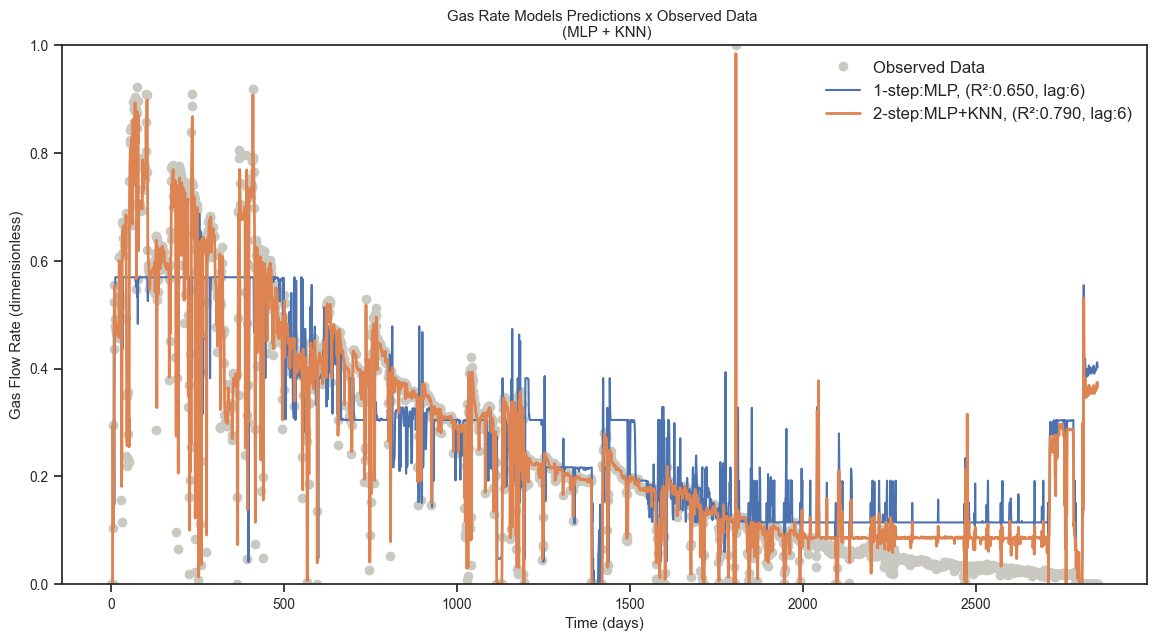

In [100]:
fig = plt.figure(figsize=(14,7))
plt.plot(y_te, 'o', label='Observed Data', c='#c9c9c1')

# plot best modl predictions
plt.plot(y_hat_te_fs, label=f"1-step:{df2.loc[264,'BASE_MODEL']}, (R²:{df2.loc[264,'R2_TEST_FS']:.3f}, lag:{df2.loc[264,'ORDER']})")
plt.plot(yf_hat_te_fs, label=f"2-step:{df2.loc[268,'BASE_MODEL']}+{df2.loc[268,'RESIDUAL_MODEL']}, (R²:{df2.loc[268,'R2_TEST_FS']:.3f}, lag:{df2.loc[268,'ORDER']})", lw=2)
plt.legend()

plt.ylim((0,1))

plt.ylabel('Gas Flow Rate (dimensionless)')
plt.xlabel('Time (days)')
plt.legend(fontsize='12', loc='upper right')
plt.title('Gas Rate Models Predictions x Observed Data \n (MLP + KNN)')

# p = os.path.join(os.getcwd(), 'outputs', 'images_ensembles', '6_predictions_best_W1Lin.eps')
# fig.savefig(p, format='eps')
pass;
